In [1]:
# >>>-------------------------> Import Libraries
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
import xarray as xr                      
from datetime import date, time, datetime 
import scipy.io
from scipy.io import loadmat
from scipy import interpolate
import datetime as dt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import glob

In [2]:
# >>>------------------------->  Function to convert datenum to datetime
def matlab2datetime(matlab_datenum):
    day = dt.datetime.fromordinal(int(matlab_datenum))
    dayfrac = dt.timedelta(days=int(matlab_datenum%1)) - dt.timedelta(days = 366)
    return day + dayfrac

In [3]:
# >>>------------------------->  Load in datasets
modeldata = scipy.io.loadmat('Routine_v020721.mat')
alongtrackdata = xr.open_dataset('/Users/emmagurcan/Documents/JPL_2021/along-track data/Sentinel3A_NRT_2019_2020.nc')

# >>>-------------------------> Read in variables
# a=along-track
aadt = alongtrackdata['adt'][0:5,:,:] # note I selected only first 5 cycles which correspond to model time period
alon = alongtrackdata['longitude'].values
alat = alongtrackdata['latitude'].values
atime = alongtrackdata['time'][0:5,:,:]
acycle = alongtrackdata['cycle'][0:5]
# m=model
madt = modeldata['adt2']
mlon = modeldata['lon']
mlat = modeldata['lat']
mtime = modeldata['t']

# >>>-------------------------> Format model time
# Convert from Datenum --> Datetime format

# Initialize variable
mtimep = np.ndarray(shape=(len(mtime)), dtype = 'datetime64[ns]'); mtimep[:] = np.datetime64("NaT")

# Run function for each time step
for i in range(len(mtime)):
     mtimep[i] = matlab2datetime(mtime[i])

In [4]:
# >>>--------------> Cut alongtrack domain to the same size as model domain
### This avoids extrapolation when running the interpolation function ###

# Initialize new lon/lat variables 
x_new = np.empty(shape=(len(acycle),len(alon[:,0]),len(alon[0,:]))); x_new[:] = np.NaN
y_new = np.empty(shape=(len(acycle),len(alon[:,0]),len(alon[0,:]))); y_new[:] = np.NaN
z_at = np.empty(shape=(len(acycle),len(alon[:,0]),len(alon[0,:]))); y_new[:] = np.NaN
t_new = np.ndarray(shape=(len(acycle),len(alon[:,0]),len(alon[0,:])), dtype = 'datetime64[ns]'); t_new[:] = np.datetime64("NaT")

# >>>-------------------------> In Space
# Initialize variables for Loop
ix = 0
c = 0
        
# Loop thru lon/lat to save only along-track lon/lat within limits of model domain.
for jy in range(len(alon[0,:])):
    while ix < len(alon):
        if alon[ix,jy] <= (np.max(mlon)) and alon[ix,jy] >= (np.min(mlon)) and alat[ix,jy] <= (np.max(mlat)) and alat[ix,jy] >= (np.min(mlat)):
            x_new[:,c,jy] = np.matlib.repmat(alon[ix,jy],1,len(acycle))
            y_new[:,c,jy] = np.matlib.repmat(alat[ix,jy],1,len(acycle))
            t_new[:,c,jy] = atime[:,ix,jy]
            z_at[:,c,jy] = aadt[:,ix,jy] # save this for comparing to interpolated data at the end
            c += 1       
        ix += 1
    c = 0
    ix = 0
    
# >>>-------------------------> In Time
# Remove any alongtrack time period outside of model period 

# Find where observation time outside model time
index = np.where((t_new < mtimep[0]) | (t_new > mtimep[-1]))

# Set this time to Not a Time
t_new[index] = np.datetime64("NaT")

In [5]:
# >>>-------------------------> Interpolate model XYT onto alongtrack XYT

# Prepare simple variables for input
x = mlon[:,0]
y = mlat[0,:]
t = mtimep.astype("float")
z = madt

# Initialize new z variable
z_new = np.empty(np.shape(t_new)); z_new[:] = np.NaN

#  Interpolate
d = (x,y,t) # tuple
ints = interpolate.RegularGridInterpolator(d, z) # create interpolation function
z_new[~np.isnat(t_new)] = ints((x_new[~np.isnat(t_new)],y_new[~np.isnat(t_new)],t_new[~np.isnat(t_new)])) # run interpolation for all values not NaN/NaT

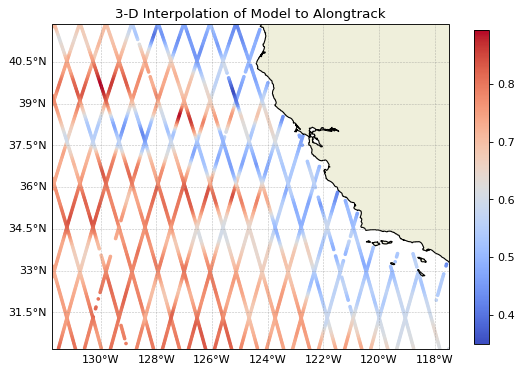

In [6]:
# >>>-------------------------> Plot to Check

# Choose cycle to plot
cycnum = 2
xx = x_new[cycnum,:,:]
yy = y_new[cycnum,:,:]
zz = z_new[cycnum,:,:]

fig = plt.figure(figsize = (8, 8), dpi = 80)
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([min(xx[~np.isnan(xx)]), max(xx[~np.isnan(xx)]), min(yy[~np.isnan(yy)]), max(yy[~np.isnan(yy)])], crs=ccrs.PlateCarree()) # define limits using data
gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=.5, color='gray', alpha=0.5, linestyle='--') # include gridlines on map
gl.top_labels = False     # don't want to plot labels on top side
gl.right_labels = False  
plt.scatter(xx,yy, s=5, c=zz, cmap='coolwarm')
# coastlines
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)

cbar = plt.colorbar(shrink=0.65) 

plt.title('3-D Interpolation of Model to Alongtrack')
plt.show()

<ipython-input-7-9f5f1ff37024>:5: RuntimeWarning: overflow encountered in multiply
  obs = z_at*100
<ipython-input-7-9f5f1ff37024>:5: RuntimeWarning: invalid value encountered in multiply
  obs = z_at*100
<ipython-input-7-9f5f1ff37024>:6: RuntimeWarning: Mean of empty slice
  rmsd = np.sqrt(np.nanmean((model-obs)**2,axis=0))


Text(0.5, 1.0, 'RMSD between Model and Alongtrack')

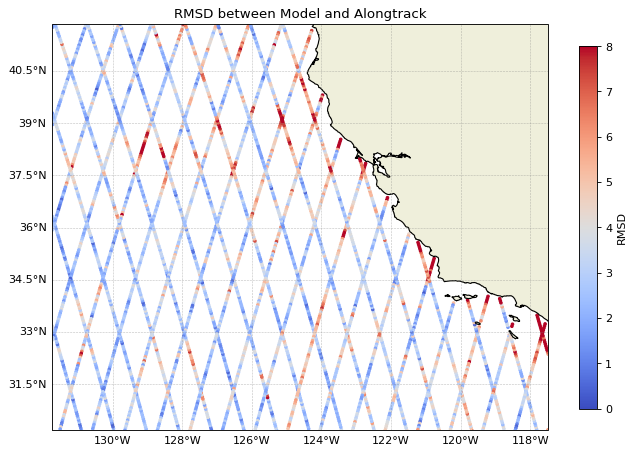

In [7]:
# >>>-------------------------> Plot Root Mean Square Difference (RMSD) between Model and AlongTrack

# Calculate RMSD in time
model = z_new*100
obs = z_at*100
rmsd = np.sqrt(np.nanmean((model-obs)**2,axis=0))

# Plot Figure

# Set up figure axes
fig = plt.figure(figsize=(10, 8), dpi=80) # make the figure larger
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree()) # define the map projection
ax.set_extent([min(xx[~np.isnan(xx)]), max(xx[~np.isnan(xx)]), min(yy[~np.isnan(yy)]), max(yy[~np.isnan(yy)])], crs=ccrs.PlateCarree()) # define limits using data
gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=.5, color='gray', alpha=0.5, linestyle='--') # include gridlines on map
gl.top_labels = False     # don't want to plot labels on top side
gl.right_labels = False   # don't want to plot labels on right-hand side

plt.scatter(xx,yy, s=5, c=rmsd, vmin=0,vmax=8, cmap='coolwarm')

# coastlines
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
    
cbar = plt.colorbar(shrink=0.75) 
cbar.set_label('RMSD')
plt.title('RMSD between Model and Alongtrack')


/Users/emmagurcan/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Text(0.5, 1.0, 'Standard Deviation of Model Mean')

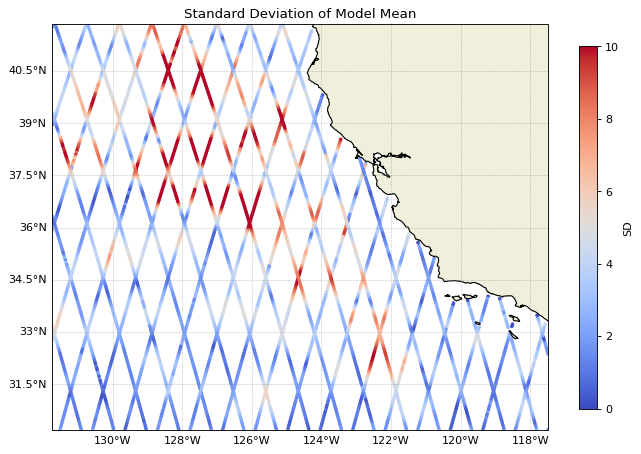

In [8]:
# >>>-------------------------> Plot Standard Deviation (STD) of Model OR Alongtrack

# Calculate RMSD in time
model = z_new*100
obs = aadt*100
std = np.nanstd(model,axis=0)

# Plot Figure

# Set up figure axes
fig = plt.figure(figsize=(10, 8), dpi=80) # make the figure larger
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree()) # define the map projection
ax.set_extent([min(xx[~np.isnan(xx)]), max(xx[~np.isnan(xx)]), min(yy[~np.isnan(yy)]), max(yy[~np.isnan(yy)])], crs=ccrs.PlateCarree()) # define limits using data
gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=.5, color='gray', alpha=0.5, linestyle='--') # include gridlines on map
gl.top_labels = False     # don't want to plot labels on top side
gl.right_labels = False   # don't want to plot labels on right-hand side

plt.scatter(xx,yy, s=5, c=std, vmin=0,vmax=10, cmap = 'coolwarm')

# coastlines
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
    
cbar = plt.colorbar(shrink=0.75) 
cbar.set_label('SD')
plt.title('Standard Deviation of Model Mean')
